In [1]:
%pylab inline
import uproot
import pandas as pd
import awkward as ak
from yahist import Hist1D, Hist2D
from yahist.utils import plot_stack
import mplhep as hep
plt.style.use(hep.styles.CMS)
from scipy.stats import gaussian_kde

Populating the interactive namespace from numpy and matplotlib


In [2]:
process_ids = {}
process_ids["Data"] = 0

process_ids["HH_ggTauTau"] = -1
#process_ids["HH_ggZZ"] = -2
#process_ids["HH_ggZZ_4l"] = -5
#process_ids["HH_ggZZ_2l2q"] = -6
process_ids["HH_ggWW_dileptonic"] = -3
process_ids["HH_ggWW_semileptonic"] = -4

process_ids["DiPhoton"] = 3
process_ids["GJets"] = 8
process_ids["TTGG"] = 7
process_ids["TTGamma"] = 6
process_ids["TTbar"] = 5
process_ids["VH"] = 9
process_ids["WGamma"] = 4
process_ids["ZGamma"] = 2
process_ids["ttH"] = 10
process_ids["ggH"] = 11
process_ids["VBFH"] = 12

In [3]:
is_resonant = {}

is_resonant["Data"] = False
is_resonant["DiPhoton"] = False
is_resonant["GJets"] = False
is_resonant["HH_ggTauTau"] = True
is_resonant["HH_ggZZ"] = True
is_resonant["HH_ggWW_dileptonic"] = True
is_resonant["HH_ggWW_semileptonic"] = True
is_resonant["HH_ggZZ_4l"] = True
is_resonant["HH_ggZZ_2l2q"] = True
is_resonant["TTGG"] = False
is_resonant["TTGamma"] = False
is_resonant["TTbar"] = False
is_resonant["VH"] = True
is_resonant["WGamma"] = False
is_resonant["ZGamma"] = False
is_resonant["ttH"] = True
is_resonant["ggH"] = True
is_resonant["VBFH"] = True

In [4]:
colors = {}
colors["Data"] = "k"
colors["DiPhoton"] = "C0"
colors["GJets"] = "C1"
colors["HH_ggTauTau"] = "k"
colors["HH_ggZZ"] = "b"
colors["HH_ggWW"] = "g"
colors["TTbar"] = "C3"
colors["VH"] = "C4"
colors["WGamma"] = "C5"
colors["ZGamma"] = "C6"
colors["ttH"] = "C7"
colors["ggH"] = "C8"
colors["VBFH"] = "C2"

In [5]:
t = uproot.open("../output/run2_all_with_isoTrack_isolation_no_HHggZZ.root")["t"]
master_df = t.arrays(library="pd")

In [6]:
t = uproot.open("GJets_background.root")["t"]
gjets_df = t.arrays(library="pd")

### Category wise normalization

In [7]:
mgg_binning = "1,100,180" # ROOT convention
all_hists = {}
scale_factors = {}
for Category in range(1,9):
    mgg_hists = {}
    for process, process_id in process_ids.items():
        if is_resonant[process] and "HH_gg" not in process:
            continue
        if process == "GJets":
            toFill = gjets_df.loc[gjets_df["Category"] == Category, "mgg"]
            weight = gjets_df.loc[gjets_df["Category"] == Category, "weight"] 
        else:
            toFill = master_df.loc[(master_df["Category"] == Category) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
            weight = master_df.loc[(master_df["Category"] == Category) & (master_df["process_id"] == process_id), "weight"]
        if process in colors:
            mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, weights=weight, label=process, color=colors[process])
        else:
            mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, weights=weight, label=process)        
    mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

    background = Hist1D(np.zeros(1), bins=mgg_binning)
    background_without_gjets = Hist1D(np.zeros(1), bins=mgg_binning)
    print("Category = ", Category)
    for name, hist in mgg_hists.items():
        if "HH_gg" in name or "TTG" in name:
            continue
        if name != "Data":
            background = background + hist
            if name != "GJets":
                background_without_gjets = background_without_gjets + hist
    scale = (mgg_hists["Data"] - background_without_gjets).integral / mgg_hists["GJets"].integral
    print("Data = {}, Other backgrounds = {}, GJets = {}".format(mgg_hists["Data"].integral, background_without_gjets.integral, mgg_hists["GJets"].integral))
    print("scale factor = ", scale)
    scale_factors[Category] = scale
    mgg_hists["backgrounds"] = background
    mgg_hists["backgrounds_no_gjets"] = background_without_gjets
    all_hists[Category] = mgg_hists

Category =  1
Data = 100.0, Other backgrounds = 90.30091242335038, GJets = 69.27409851783887
scale factor =  0.14001030376673892
Category =  2
Data = 113.0, Other backgrounds = 97.0174373727059, GJets = 54.25159544800408
scale factor =  0.29460078538357715
Category =  3
Data = 247.0, Other backgrounds = 140.62142614333425, GJets = 165.5220395908691
scale factor =  0.6426852527893454
Category =  4
Data = 176.0, Other backgrounds = 177.13119880203158, GJets = 103.49808824714273
scale factor =  -0.010929658906649473
Category =  5
Data = 92.0, Other backgrounds = 148.18382005771855, GJets = 47.427011312451214
scale factor =  -1.1846375831607245
Category =  6
Data = 56.0, Other backgrounds = 39.3120617204695, GJets = 31.50855357851833
scale factor =  0.529632000972202
Category =  7
Data = 1691.0, Other backgrounds = 483.89730240707286, GJets = 1157.2795324399485
scale factor =  1.0430519712449542
Category =  8
Data = 52876.0, Other backgrounds = 17819.46535316325, GJets = 35536.47239611088


In [8]:
scale_factors[8]

0.9864945022138253

In [10]:
 gjets_df.loc[gjets_df["Category"] == 8, "weight"].sum()

35536.47

In [11]:
35536.47 * 0.986

35038.95942

In [12]:
for Category in range(1,9):
    if Category == 4 or Category == 5:
        continue
    gjets_df.loc[gjets_df["Category"] == Category, "weight"] *= scale_factors[Category]

In [14]:
# stopgap - use MC for categories 4, 5
gjets_df = gjets_df.loc[(gjets_df["Category"] < 4) | (gjets_df["Category"] > 5)].copy()

In [15]:
gjets_df = gjets_df.append(master_df.loc[((master_df["Category"] ==4) | (master_df["Category"] == 5)) & (master_df["process_id"] == 8)], ignore_index = True)

'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


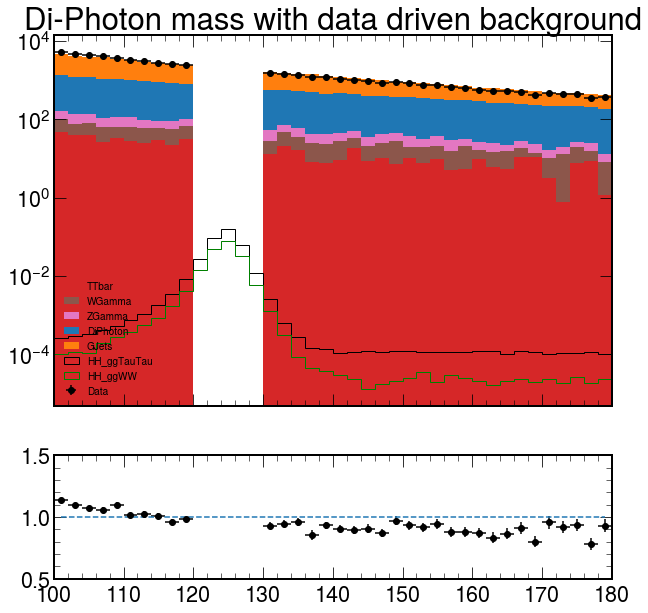

In [16]:
# Fancy stuff

mgg_binning = "40,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df["mgg"]
        weight = gjets_df["weight"]
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "mgg"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
for hist in hist_stack[1:]:
        total_background = total_background + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")
plt.ylim([0.5, 1.5])
ax1.set_title("Di-Photon mass with data driven background")
plt.savefig("mgg_data_driven.pdf")

### Yields computation

In [17]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df["mgg"]
        weight = gjets_df["weight"] 
    else:
        toFill = master_df.loc[(master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

background = Hist1D(np.zeros(1), bins=mgg_binning)
print("inclusive")
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {} $\pm$ {}".format(name, hist.integral, hist.errors[0]))
print("total background = {} $\pm$ {}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.3f} $\pm$ {:0.3f}".format(ratio.integral, ratio.errors[0]))

inclusive
Data = 55351.0 $\pm$ 235.26793236648297
DiPhoton = 16965.9700168781 $\pm$ 55.596011600011785
GJets = 36496.93939922929 $\pm$ 124.84661617464079
TTbar = 540.233864064212 $\pm$ 31.86075516239398
WGamma = 683.8292542695999 $\pm$ 29.211695381957707
ZGamma = 797.8963768780231 $\pm$ 16.889296362307064
total background = 55485.86891131922 $\pm$ 144.33389509850716
Ratio = 0.998 $\pm$ 0.005


In [18]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df.loc[gjets_df["Category"] == 8, "mgg"]
        weight = gjets_df.loc[(gjets_df["Category"] == 8), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 8) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 8) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

background = Hist1D(np.zeros(1), bins=mgg_binning)
print("1tau0lep")
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1tau0lep
Data = 52876.0 $\pm$ 229.9
DiPhoton = 16356.1 $\pm$ 54.8
GJets = 35056.5 $\pm$ 106.9
TTbar = 390.0 $\pm$ 27.8
WGamma = 633.7 $\pm$ 28.2
ZGamma = 438.7 $\pm$ 12.6
total background = 52876.0 $\pm$ 127.1
Ratio = 1.0 $\pm$ 0.00


In [20]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df.loc[gjets_df["Category"] == 7, "mgg"]
        weight = gjets_df.loc[(gjets_df["Category"] == 7), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 7) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 7) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("1 tau0lep_iso")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1 tau0lep_iso
Data = 1691.0 $\pm$ 41.1
DiPhoton = 405.9 $\pm$ 7.3
GJets = 1207.1 $\pm$ 20.3
TTbar = 34.6 $\pm$ 7.9
WGamma = 25.2 $\pm$ 4.6
ZGamma = 17.2 $\pm$ 2.5
total background = 1691.0 $\pm$ 23.6
Ratio = 1.0 $\pm$ 0.03


In [25]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df.loc[(gjets_df["Category"] == 1) | (gjets_df["Category"] == 2), "mgg"]
        weight = gjets_df.loc[(gjets_df["Category"] == 1) | (gjets_df["Category"] == 2), "weight"] 
    else:
        toFill = master_df.loc[((master_df["Category"] == 1) | (master_df["Category"] == 2)) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[((master_df["Category"] == 1) | (master_df["Category"] == 2)) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("1tau1lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

1tau1lep
Data = 213.0 $\pm$ 14.6
DiPhoton = 31.8 $\pm$ 2.0
GJets = 25.7 $\pm$ 1.4
TTbar = 56.0 $\pm$ 9.0
WGamma = 20.0 $\pm$ 5.1
ZGamma = 77.6 $\pm$ 5.4
total background = 212.0 $\pm$ 12.0
Ratio = 1.0 $\pm$ 0.09


In [26]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df.loc[gjets_df["Category"] == 3, "mgg"]
        weight = gjets_df.loc[(gjets_df["Category"] == 3), "weight"] 
    else:
        toFill = master_df.loc[(master_df["Category"] == 3) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[(master_df["Category"] == 3) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("2tau0lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

2tau0lep
Data = 247.0 $\pm$ 15.7
DiPhoton = 112.3 $\pm$ 4.3
GJets = 106.4 $\pm$ 4.8
TTbar = 11.8 $\pm$ 2.9
WGamma = -0.3 $\pm$ 2.4
ZGamma = 15.9 $\pm$ 2.4
total background = 247.0 $\pm$ 7.9
Ratio = 1.0 $\pm$ 0.07


In [27]:
mgg_binning = "1,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df.loc[(gjets_df["Category"] == 4) | (gjets_df["Category"] == 5) | (gjets_df["Category"] == 6), "mgg"]
        weight = gjets_df.loc[((gjets_df["Category"] == 4)| (gjets_df["Category"] == 5) | (gjets_df["Category"] == 6)), "weight"] 
    else:
        toFill = master_df.loc[((master_df["Category"] == 4) | (master_df["Category"] == 5) | (master_df["Category"] == 6)) & (master_df["process_id"] == process_id), "mgg"] # select by process, then select the quantity
        weight = master_df.loc[((master_df["Category"] == 4) | (master_df["Category"] == 5) | (master_df["Category"] == 6)) & (master_df["process_id"] == process_id), "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]
print("0tau2lep")
background = Hist1D(np.zeros(1), bins=mgg_binning)
for name, hist in mgg_hists.items():
    if "HH_gg" in name or "TTG" in name:
        continue
    if name != "Data":
        background = background + hist
    print("{} = {:0.1f} $\pm$ {:0.1f}".format(name, hist.integral, hist.errors[0]))
print("total background = {:0.1f} $\pm$ {:0.1f}".format(background.integral,background.errors[0]))
ratio = mgg_hists["Data"] / background
print("Ratio = {:0.1f} $\pm$ {:0.2f}".format(ratio.integral, ratio.errors[0]))

0tau2lep
Data = 324.0 $\pm$ 18.0
DiPhoton = 60.0 $\pm$ 2.9
GJets = 101.2 $\pm$ 61.0
TTbar = 47.8 $\pm$ 9.4
WGamma = 5.3 $\pm$ 2.3
ZGamma = 248.6 $\pm$ 9.3
total background = 463.9 $\pm$ 62.5
Ratio = 0.7 $\pm$ 0.10


In [ ]:
with uproot.recreate("GJets_scaled.root") as f:
    f["t"] = gjets_df_new

In [ ]:
with uproot.open("../BDT/20220117_data_driven_mc_blended.root") as f:
    data_df = f["t"].arrays(library="pd")

In [ ]:
t = uproot.open("../BDT/20220112_mc_only_zipped.root")["t"]
mc_df = t.arrays(library="pd")

In [ ]:
mgg_binning = "20,0,1" # ROOT convention

data_mva_hists = {}
for process, process_id in process_ids.items():
    toFill = data_df.loc[data_df["process_id"] == process_id, "bdt_data_driven"] # select by process, then select the quantity
    weight = data_df.loc[data_df["process_id"] == process_id, "weight"]
    if process in colors:
        data_mva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        data_mva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
data_mva_hists["TTbar"] += data_mva_hists["TTGamma"] + data_mva_hists["TTGG"]

hist_stack = [hist for process, hist in data_mva_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
data_mva_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


data_mva_hists["HH_ggWW"] = data_mva_hists["HH_ggWW_dileptonic"] + data_mva_hists["HH_ggWW_semileptonic"]
data_mva_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
data_mva_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
for hist in hist_stack[1:]:
        total_background = total_background + hist
ratio_hist = data_mva_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)
ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")
ax1.set_title("MVA scores data driven $\gamma$ + Jets")
plt.savefig("data_driven_mva_scores.pdf")

In [ ]:
mgg_binning = "20,0,1" # ROOT convention

mc_mva_hists = {}
for process, process_id in process_ids.items():
    toFill = mc_df.loc[mc_df["process_id"] == process_id, "bdt_mc_only"] # select by process, then select the quantity
    weight = mc_df.loc[mc_df["process_id"] == process_id, "weight"]
    if process in colors:
        mc_mva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mc_mva_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mc_mva_hists["TTbar"] += mc_mva_hists["TTGamma"] + mc_mva_hists["TTGG"]

hist_stack = [hist for process, hist in mc_mva_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mc_mva_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mc_mva_hists["HH_ggWW"] = mc_mva_hists["HH_ggWW_dileptonic"] + mc_mva_hists["HH_ggWW_semileptonic"]
mc_mva_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mc_mva_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
for hist in hist_stack[1:]:
        total_background = total_background + hist
ratio_hist = mc_mva_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)
ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")
ax1.set_title("MVA score MC only")
plt.savefig("mc_only_mva_scores.pdf")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))
plt.sca(ax1)
data_mva_hists["Data"].plot(show_errors=True, label="Data driven BDT")
mc_mva_hists["Data"].plot(color="C0", histtype="stepfilled", label="MC only BDT")
plt.title("Data vs data MVA score comparison")
plt.yscale("log")
plt.sca(ax2)
ratio_hist = data_mva_hists["Data"].copy()
ratio_hist /= mc_mva_hists["Data"]
ratio_hist.plot(show_errors=True, legend=False)
plt.plot(linspace(0,1,50), np.ones(50), "--")
plt.savefig("mva_score_compare.pdf")

In [ ]:
mgg_binning = "40,100,180" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    toFill = master_df.loc[master_df["process_id"] == process_id, "mgg"] # select by process, then select the quantity
    weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Di-Photon mass Non-resonant backgrounds")
plt.savefig("mgg_mc_only.pdf")

In [ ]:
master_df["max_gamma_idmva"] = np.zeros(len(master_df))
master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "max_gamma_idmva"] =master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "g1_idmva"]
master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "max_gamma_idmva"] =master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "g2_idmva"]

In [ ]:
master_df["min_gamma_idmva"] = np.zeros(len(master_df))
master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "min_gamma_idmva"] =master_df.loc[(master_df["g1_idmva"] > master_df["g2_idmva"]), "g2_idmva"]
master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "min_gamma_idmva"] =master_df.loc[(master_df["g2_idmva"] > master_df["g1_idmva"]), "g1_idmva"]

In [ ]:
gjets_df["min_gamma_idmva"] = np.zeros(len(gjets_df))
gjets_df.loc[(gjets_df["g1_idmva"] > gjets_df["g2_idmva"]), "min_gamma_idmva"] =gjets_df.loc[(gjets_df["g1_idmva"] > gjets_df["g2_idmva"]), "g2_idmva"]
gjets_df.loc[(gjets_df["g2_idmva"] > gjets_df["g1_idmva"]), "min_gamma_idmva"] =gjets_df.loc[(gjets_df["g2_idmva"] > gjets_df["g1_idmva"]), "g1_idmva"]

In [ ]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df["max_gamma_idmva"]
        weight = gjets_df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "max_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
# plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Max $\gamma$ MVA ID data driven background")
plt.savefig("max_gamma_idmva_data_driven.pdf")

In [ ]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    toFill = master_df.loc[master_df["process_id"] == process_id, "max_gamma_idmva"] # select by process, then select the quantity
    weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
# plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Max $\gamma$ MVA ID MC only background")
plt.savefig("max_gamma_idmva_mc_only.pdf")

In [ ]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
    if process == "GJets":
        toFill = gjets_df["min_gamma_idmva"]
        weight = gjets_df["weight"] #* scale_factor
    else:
        toFill = master_df.loc[master_df["process_id"] == process_id, "min_gamma_idmva"] # select by process, then select the quantity
        weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
# plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Min $\gamma$ MVA ID data driven background")
plt.savefig("min_gamma_idmva_data_driven.pdf")

In [ ]:
mgg_binning = "30,-0.7,1" # ROOT convention

mgg_hists = {}
for process, process_id in process_ids.items():
    if is_resonant[process] and "HH_gg" not in process:
        continue
   # if process == "GJets":
   #     toFill = gjets_df["min_gamma_idmva"]
   #     weight = gjets_df["weight"] #* scale_factor
    #else:
    toFill = master_df.loc[master_df["process_id"] == process_id, "min_gamma_idmva"] # select by process, then select the quantity
    weight = master_df.loc[master_df["process_id"] == process_id, "weight"]
    if process in colors:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight, color=colors[process])
    else:
        mgg_hists[process] = Hist1D(toFill.values, bins=mgg_binning, label=process, weights=weight)        

# plots
# stack non-signals
mgg_hists["TTbar"] += mgg_hists["TTGamma"] + mgg_hists["TTGG"]

hist_stack = [hist for process, hist in mgg_hists.items() if "HH_gg" not in process and process != "Data" and "TTG" not in process]
hist_stack = sorted(hist_stack, key=lambda x: x.integral)
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw=dict(height_ratios=[3, 1]))

plot_stack(hist_stack, ax=ax1, histtype="stepfilled")
mgg_hists["Data"].plot(ax=ax1, show_errors=True, color="k")


# mgg_hists["HH_ggWW"] = mgg_hists["HH_ggWW_dileptonic"] + mgg_hists["HH_ggWW_semileptonic"]
# mgg_hists["HH_ggTauTau"].plot(ax=ax1, color=colors["HH_ggTauTau"], histtype="step")
# mgg_hists["HH_ggWW"].plot(ax=ax1, histtype="step", color=colors["HH_ggWW"], label="HH_ggWW")
#plt.title("Di-Photon Mass Non-resonant backgrounds Category 3")
ax1.set_yscale("log")
ax1.legend(fontsize=10)

total_background = hist_stack[0].copy()
total_except_GJets = hist_stack[0].copy()
for hist in hist_stack[1:]:
    total_background = total_background + hist
    if hist.metadata["label"] != "GJets":
        total_except_GJets = total_except_GJets + hist
ratio_hist = mgg_hists["Data"].copy()
ratio_hist = (ratio_hist / total_background)

ratio_hist.plot(ax=ax2, show_errors=True, legend=False)
plt.sca(ax2)
# plt.ylim([0.5,1.5])
plt.plot(ratio_hist.bin_centers, np.ones_like(ratio_hist.bin_centers), "--")

ax1.set_title("Min $\gamma$ MVA ID MC only background")
plt.savefig("min_gamma_idmva_mc_only.pdf")